# Baseline Function Comparison

This notebook systematically compares different baseline functions B(x) to determine which best fits the ethical prime distribution Π(x).

## Theory

The baseline function B(x) represents the expected number of ethical primes up to complexity x. Different forms have different theoretical justifications:

1. **Linear**: B(x) = αx - Simple linear growth
2. **Prime Theorem**: B(x) = βx/log(x) - Direct analogy to Prime Number Theorem
3. **Logarithmic Integral**: B(x) = β·Li(x) where Li(x) = ∫₂ˣ dt/log(t) - Standard form in number theory
4. **Power Law**: B(x) = γx^δ - Flexible power law form

We compare these using statistical metrics:
- **R²**: Coefficient of determination (higher is better)
- **AIC**: Akaike Information Criterion (lower is better)
- **BIC**: Bayesian Information Criterion (lower is better)
- **RMSE**: Root Mean Squared Error (lower is better)


In [1]:
import sys
import os
from pathlib import Path

# Robust path setup
def setup_paths():
    current_dir = Path(os.getcwd())
    if current_dir.name == 'notebooks':
        simulation_dir = str(current_dir.parent)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    elif current_dir.name == 'simulation':
        simulation_dir = str(current_dir)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    for parent in current_dir.parents:
        if parent.name == 'simulation':
            simulation_dir = str(parent)
            if simulation_dir not in sys.path:
                sys.path.insert(0, simulation_dir)
            return simulation_dir
    for path in ['..', '../simulation', 'simulation']:
        abs_path = os.path.abspath(path)
        if abs_path not in sys.path:
            sys.path.insert(0, abs_path)
    return None

setup_paths()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from core.action_space import generate_world
from core.judgement_system import BiasedJudge, NoisyJudge, ConservativeJudge, RadicalJudge, evaluate_judgement
from core.ethical_primes import select_ethical_primes, compute_Pi_and_error
from analysis.baseline_comparison import (
    compare_all_baselines, select_best_baseline, generate_baseline_comparison_report
)
from visualization.plots import setup_paper_style

setup_paper_style()
np.random.seed(42)


## Generate Data

Create a moral action space and evaluate with different judgment systems.


In [2]:
# Generate action space
num_actions = 2000
actions = generate_world(num_actions=num_actions, complexity_dist='zipf', random_seed=42)

# Create judges to compare
judges = {
    'Biased': BiasedJudge(bias_strength=0.2, noise_scale=0.1),
    'Noisy': NoisyJudge(noise_scale=0.3),
    'Conservative': ConservativeJudge(threshold=0.5),
    'Radical': RadicalJudge(amplification=1.5)
}

# Evaluate all judges
tau = 0.3
results = {}
for name, judge in judges.items():
    actions_copy = [a for a in actions]  # Copy to avoid modifying original
    evaluate_judgement(actions_copy, judge, tau=tau)
    primes = select_ethical_primes(actions_copy, importance_quantile=0.9)
    results[name] = {
        'actions': actions_copy,
        'primes': primes
    }
    print(f"{name:15s}: {len(primes)} ethical primes")

print(f"\nTotal actions: {num_actions}")


Biased         : 23 ethical primes
Noisy          : 46 ethical primes
Conservative   : 110 ethical primes
Radical        : 26 ethical primes

Total actions: 2000


## Compare Baselines for Each Judge

Compare all baseline functions and identify the best fit for each judgment system.


In [3]:
X_max = 100
all_comparisons = {}
all_best = {}

for judge_name, data in results.items():
    primes = data['primes']
    
    # Compute Pi(x)
    Pi_x, _, _, x_vals = compute_Pi_and_error(primes, X_max=X_max, baseline='linear')
    
    # Compare all baselines
    comparison = compare_all_baselines(x_vals, Pi_x, optimize_params=True)
    all_comparisons[judge_name] = comparison
    
    # Select best by AIC
    best_type, best_B_x, best_params = select_best_baseline(comparison, criterion='aic')
    all_best[judge_name] = {
        'type': best_type,
        'B_x': best_B_x,
        'params': best_params
    }
    
    print(f"\n{judge_name}:")
    print(f"  Best baseline: {best_type}")
    print(f"  R² = {best_params['r_squared']:.4f}")
    print(f"  AIC = {best_params['aic']:.2f}")
    print(f"  RMSE = {best_params['rmse']:.4f}")



Biased:
  Best baseline: power_law
  R² = -7.0190
  AIC = 298.57
  RMSE = 4.3617

Noisy:
  Best baseline: power_law
  R² = -167.1373
  AIC = 567.16
  RMSE = 16.7065

Conservative:
  Best baseline: power_law
  R² = -58.2610
  AIC = 707.54
  RMSE = 33.7065

Radical:
  Best baseline: power_law
  R² = -65.0416
  AIC = 425.12
  RMSE = 8.2119


## Detailed Comparison Report

Generate detailed statistical comparison for each judge.


In [4]:
# Generate reports for each judge
for judge_name, comparison in all_comparisons.items():
    Pi_x, _, _, x_vals = compute_Pi_and_error(
        results[judge_name]['primes'], X_max=X_max, baseline='linear'
    )
    report = generate_baseline_comparison_report(comparison, x_vals, Pi_x)
    print(f"\n{'='*80}")
    print(f"REPORT FOR {judge_name.upper()}")
    print('='*80)
    print(report)



REPORT FOR BIASED
BASELINE FUNCTION COMPARISON REPORT

Number of data points: 100
Complexity range: [1.0, 100.0]
Total primes: 23

--------------------------------------------------------------------------------
Baseline Type                   R²        AIC        BIC       RMSE
--------------------------------------------------------------------------------
linear                    -50.0364     481.64     484.25    11.0036
logarithmic_integral      -779.4783     438.04     440.62     9.2506
power_law                  -7.0190     298.57     303.78     4.3617
prime_theorem             -124.8275     450.89     453.49     9.6516
--------------------------------------------------------------------------------

Best Baseline by Criterion:
  R²:   power_law
  AIC:  power_law
  BIC:  power_law
  RMSE: power_law


REPORT FOR NOISY
BASELINE FUNCTION COMPARISON REPORT

Number of data points: 100
Complexity range: [1.0, 100.0]
Total primes: 46

--------------------------------------------------

## Visualization: All Baselines Compared

Plot all baseline functions against the actual Π(x) for visual comparison.


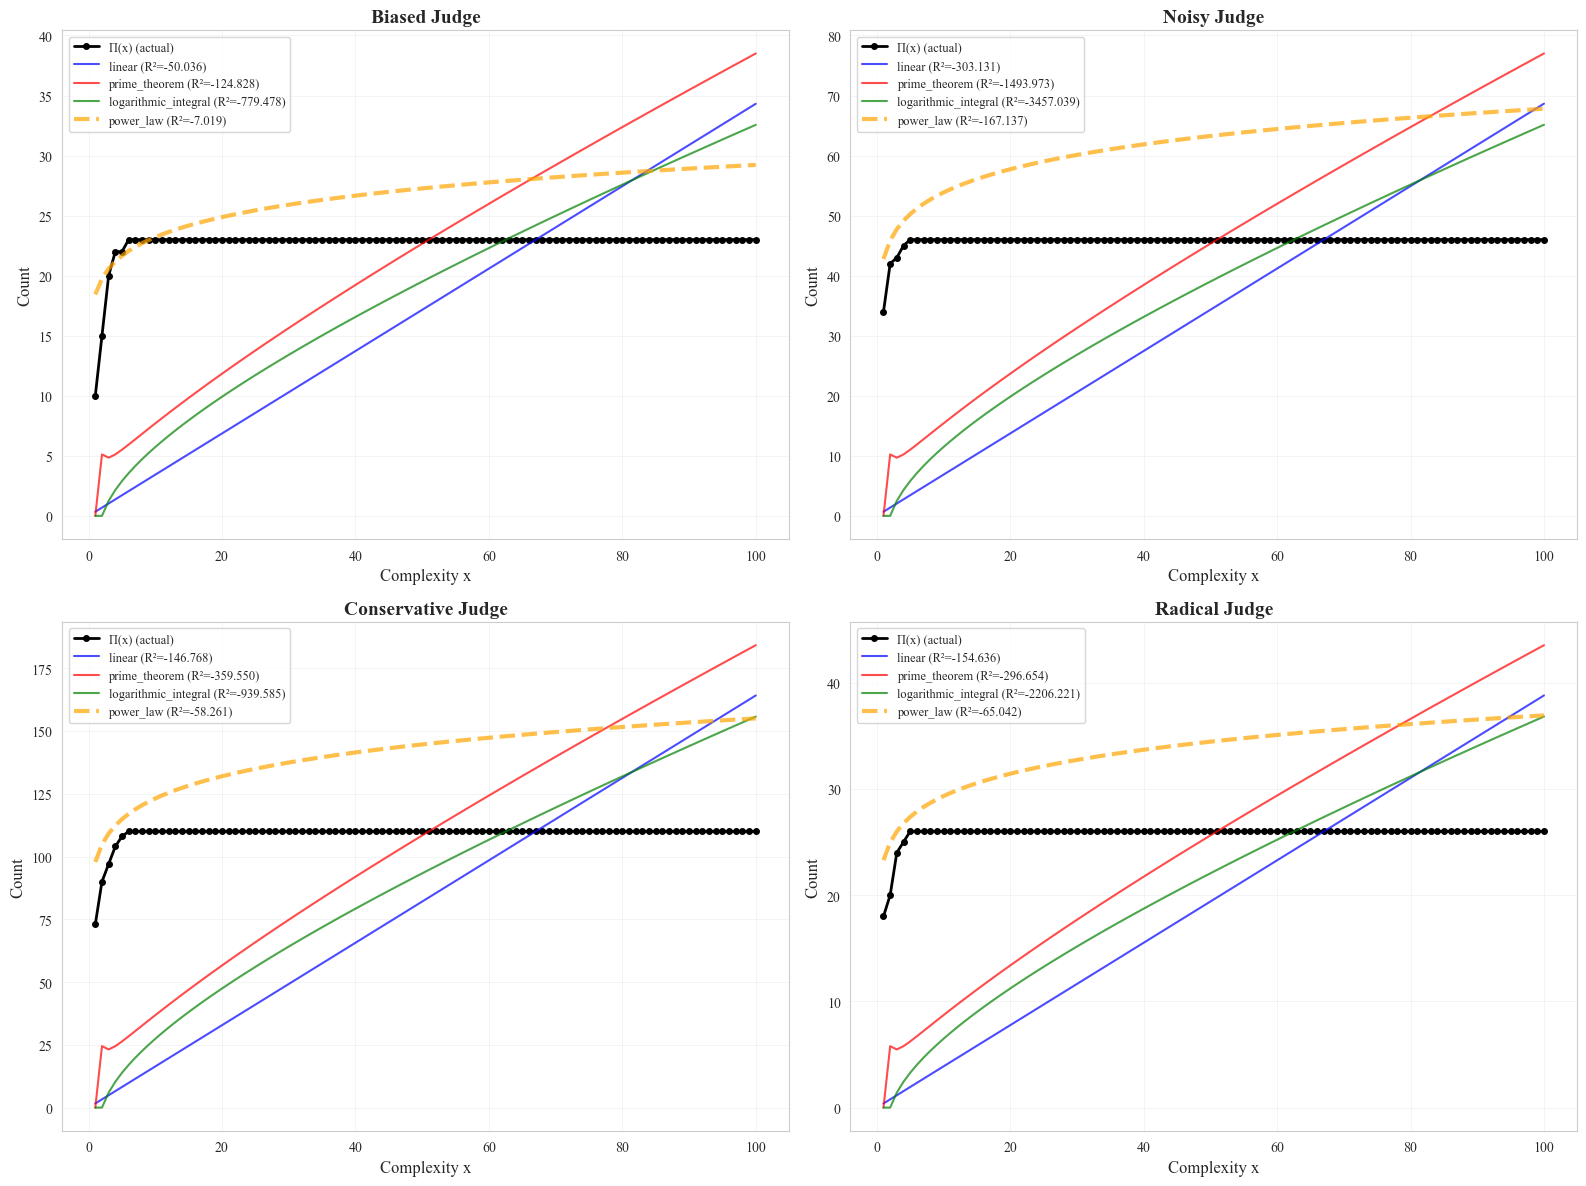

In [5]:
# Create comparison plots for each judge
n_judges = len(results)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

baseline_colors = {
    'linear': 'blue',
    'prime_theorem': 'red',
    'logarithmic_integral': 'green',
    'power_law': 'orange'
}

for idx, (judge_name, comparison) in enumerate(all_comparisons.items()):
    ax = axes[idx]
    
    # Get Pi(x)
    Pi_x, _, _, x_vals = compute_Pi_and_error(
        results[judge_name]['primes'], X_max=X_max, baseline='linear'
    )
    
    # Plot actual Pi(x)
    ax.plot(x_vals, Pi_x, 'ko-', label='Π(x) (actual)', linewidth=2, markersize=4)
    
    # Plot all baselines
    for baseline_type, (B_x, params) in comparison.items():
        color = baseline_colors.get(baseline_type, 'gray')
        linestyle = '--' if baseline_type == all_best[judge_name]['type'] else '-'
        linewidth = 3 if baseline_type == all_best[judge_name]['type'] else 1.5
        label = f"{baseline_type} (R²={params['r_squared']:.3f})"
        ax.plot(x_vals, B_x, color=color, linestyle=linestyle, 
               linewidth=linewidth, label=label, alpha=0.7)
    
    ax.set_xlabel('Complexity x', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'{judge_name} Judge', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/06_baseline_comparison.pdf', dpi=300)
plt.show()


## Summary Table

Create a summary table comparing baseline performance across all judges.


In [6]:
# Create summary DataFrame
summary_data = []
for judge_name, comparison in all_comparisons.items():
    for baseline_type, (B_x, params) in comparison.items():
        summary_data.append({
            'Judge': judge_name,
            'Baseline': baseline_type,
            'R²': params['r_squared'],
            'AIC': params['aic'],
            'BIC': params['bic'],
            'RMSE': params['rmse'],
            'Is Best': baseline_type == all_best[judge_name]['type']
        })

summary_df = pd.DataFrame(summary_data)

# Display summary
print("Summary of Baseline Comparisons:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Save to CSV
os.makedirs('../output', exist_ok=True)
summary_df.to_csv('../output/baseline_comparison_summary.csv', index=False)
print(f"\nSaved summary to: ../output/baseline_comparison_summary.csv")

# Best baseline by judge
print("\n" + "=" * 80)
print("Best Baseline for Each Judge (by AIC):")
print("=" * 80)
for judge_name, best_info in all_best.items():
    print(f"{judge_name:15s}: {best_info['type']:20s} "
          f"(R²={best_info['params']['r_squared']:.4f}, "
          f"AIC={best_info['params']['aic']:.2f})")


Summary of Baseline Comparisons:
       Judge             Baseline           R²        AIC        BIC      RMSE  Is Best
      Biased               linear   -50.036394 481.644108 484.249279 11.003579    False
      Biased        prime_theorem  -124.827509 450.891373 453.486492  9.651643    False
      Biased logarithmic_integral  -779.478335 438.038313 440.623280  9.250571    False
      Biased            power_law    -7.018968 298.571183 303.781523  4.361674     True
       Noisy               linear  -303.131072 624.427637 627.032807 22.469036    False
       Noisy        prime_theorem -1493.972777 590.818499 593.413619 19.566733    False
       Noisy logarithmic_integral -3457.038562 575.262089 577.847057 18.630622    False
       Noisy            power_law  -167.137273 567.159835 572.370176 16.706522     True
Conservative               linear  -146.768337 796.907578 799.512748 53.225515    False
Conservative        prime_theorem  -359.549738 761.929032 764.524152 46.433696    False

## Error Term Comparison

Compare the error terms E(x) = Π(x) - B(x) for different baselines to see which produces the most "well-behaved" error.


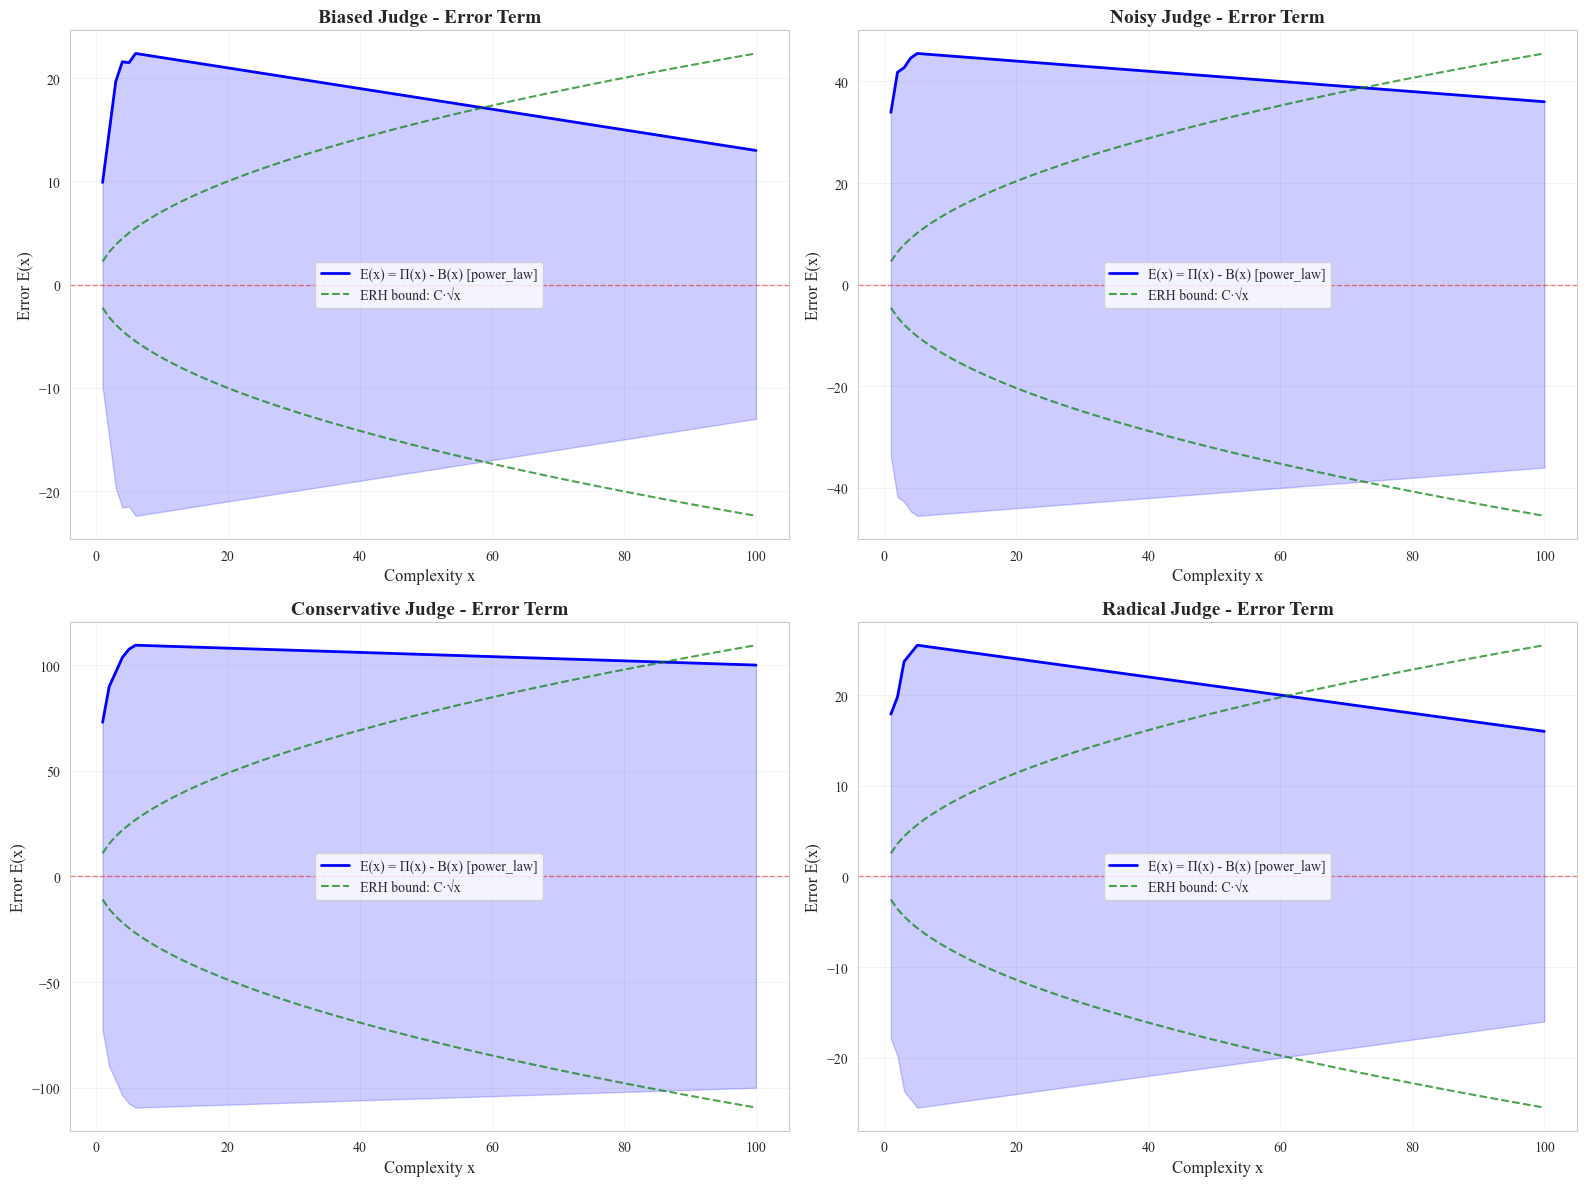

In [7]:
# Plot error terms for best baseline of each judge
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, judge_name in enumerate(results.keys()):
    ax = axes[idx]
    
    # Compute error for best baseline
    best_type = all_best[judge_name]['type']
    Pi_x, B_x, E_x, x_vals = compute_Pi_and_error(
        results[judge_name]['primes'], 
        X_max=X_max, 
        baseline=best_type
    )
    
    # Plot error term
    ax.plot(x_vals, E_x, 'b-', linewidth=2, label=f'E(x) = Π(x) - B(x) [{best_type}]')
    ax.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)
    ax.fill_between(x_vals, -np.abs(E_x), np.abs(E_x), alpha=0.2, color='blue')
    
    # Add ERH bound visualization (C * x^0.5)
    C = np.max(np.abs(E_x)) / np.sqrt(x_vals[-1])
    erh_bound = C * np.sqrt(x_vals)
    ax.plot(x_vals, erh_bound, 'g--', linewidth=1.5, label='ERH bound: C·√x', alpha=0.7)
    ax.plot(x_vals, -erh_bound, 'g--', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('Complexity x', fontsize=12)
    ax.set_ylabel('Error E(x)', fontsize=12)
    ax.set_title(f'{judge_name} Judge - Error Term', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/06_error_terms_comparison.pdf', dpi=300)
plt.show()


## Conclusions

Based on the comparison, we can determine:
1. Which baseline form best fits each judge type
2. Whether the choice of baseline affects ERH satisfaction
3. Recommendations for baseline selection in future analyses


In [8]:
print("CONCLUSIONS AND RECOMMENDATIONS")
print("=" * 80)

# Count how many times each baseline is best
baseline_counts = {}
for judge_name, best_info in all_best.items():
    best_type = best_info['type']
    baseline_counts[best_type] = baseline_counts.get(best_type, 0) + 1

print("\nBest Baseline Frequency:")
for baseline_type, count in sorted(baseline_counts.items(), key=lambda x: -x[1]):
    print(f"  {baseline_type:25s}: {count}/{len(results)} judges")

print("\nRecommendations:")
print("  1. Use 'auto' baseline option to automatically select best fit")
print("  2. For theoretical consistency, 'prime_theorem' or 'logarithmic_integral' are preferred")
print("  3. Check R² and AIC to ensure good fit quality")
print("  4. Consider judge-specific baseline selection for most accurate analysis")

print("\n" + "=" * 80)


CONCLUSIONS AND RECOMMENDATIONS

Best Baseline Frequency:
  power_law                : 4/4 judges

Recommendations:
  1. Use 'auto' baseline option to automatically select best fit
  2. For theoretical consistency, 'prime_theorem' or 'logarithmic_integral' are preferred
  3. Check R² and AIC to ensure good fit quality
  4. Consider judge-specific baseline selection for most accurate analysis

